In [ ]:
!pip install rdkit xgboost numpy pandas scikit-learn matplotlib seaborn smogn

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import smogn


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


# import os
# folder_path = '/content/drive/MyDrive/pharmahacks_2025/csv_tables'

In [ ]:
%pip install gdown
import gdown
url = "https://drive.google.com/drive/folders/1pFuFpNtd6oh2w6Ga7PRlt0kjjwbDjXTP?usp=sharing"
gdown.download_folder(url, quiet=True)

['/content/csv_tables/table-2.csv',
 '/content/csv_tables/table-1.csv',
 '/content/csv_tables/table-3.csv',
 '/content/csv_tables/table-3_NA.csv',
 '/content/csv_tables/table-3_0.csv',
 '/content/csv_tables/Copie de table-3_0.csv',
 '/content/csv_tables/table-3']

In [ ]:
# loading tables
# table1 = pd.read_csv(os.path.join(folder_path, 'table-1.csv'))
# table2 = pd.read_csv(os.path.join(folder_path, 'table-2.csv'))
# table3 = pd.read_csv(os.path.join(folder_path, 'table-3.csv'))

table1 = pd.read_csv('csv_tables/table-1.csv')
table2 = pd.read_csv('csv_tables/table-2.csv')
# table3 = pd.read_csv('csv_tables/table-3.csv')
# table3 = pd.read_csv('csv_tables/table-3_0.csv')
table3 = pd.read_csv('csv_tables/table-3_NA.csv')

In [ ]:
compound_columns = table3.columns[3:]
print(compound_columns)

Index(['A-674563', 'AB-1010', 'ABT-869', 'AC220', 'AG-013736', 'AST-487',
       'AT-7519', 'AZD-1152HQPA', 'AZD-2171', 'AZD-6244/ARRY-886', 'BI-2536',
       'BIBW-2992', 'BIRB-796', 'BMS-345541', 'BMS-387032/SNS-032',
       'BMS-540215', 'CEP-701', 'CHIR-258/TKI-258', 'CHIR-265/RAF-265',
       'CI-1033', 'CP-690550', 'Crizotinib', 'Dasatinib', 'Erlotinib',
       'EXEL-2880/GSK-1363089', 'Flavopiridol', 'GDC-0879', 'GDC-0941',
       'Gefitinib', 'GSK-1838705A', 'GSK-690693', 'GW-2580', 'HKI-272',
       'Imatinib', 'INCB18424', 'JNJ-28312141', 'Ki-20227', 'KW-2449',
       'Lapatinib', 'LY-317615', 'LY-333531', 'MLN-120B', 'MLN-518',
       'MLN-8054', 'Nilotinib', 'Pazopanib', 'PD-173955', 'PHA-665752',
       'PKC-412', 'PLX-4720', 'PP-242', 'PTK-787', 'R406', 'R547', 'SB-203580',
       'SGX-523', 'Staurosporine', 'TAE-684', 'TG-101348', 'Vandetanib'],
      dtype='object')


In [ ]:
# reshape table3 to long format
binding_data = pd.melt(
    table3,
    id_vars=['Accession Number', 'Entrez Gene Symbol', 'Kinase'],
    value_vars=compound_columns,
    var_name='Compound',
    value_name='Kd'
)

print(binding_data.head(10))

  Accession Number Entrez Gene Symbol                         Kinase  \
0      NP_055726.3               AAK1                           AAK1   
1      NP_005148.2               ABL1     ABL1(E255K)-phosphorylated   
2      NP_005148.2               ABL1  ABL1(F317I)-nonphosphorylated   
3      NP_005148.2               ABL1     ABL1(F317I)-phosphorylated   
4      NP_005148.2               ABL1  ABL1(F317L)-nonphosphorylated   
5      NP_005148.2               ABL1     ABL1(F317L)-phosphorylated   
6      NP_005148.2               ABL1  ABL1(H396P)-nonphosphorylated   
7      NP_005148.2               ABL1     ABL1(H396P)-phosphorylated   
8      NP_005148.2               ABL1     ABL1(M351T)-phosphorylated   
9      NP_005148.2               ABL1  ABL1(Q252H)-nonphosphorylated   

   Compound    Kd  
0  A-674563  43.0  
1  A-674563   NaN  
2  A-674563   NaN  
3  A-674563   NaN  
4  A-674563   NaN  
5  A-674563   NaN  
6  A-674563   NaN  
7  A-674563   NaN  
8  A-674563   NaN  
9  A-67

In [ ]:
# testing fingerprint generation

# aspirin
mol = Chem.MolFromSmiles("CC(=O)OC1=CC=CC=C1C(=O)O")
generator = GetMorganGenerator(radius=2, fpSize=2048)
fp = generator.GetFingerprint(mol)

arr = np.zeros((2048,), dtype=int)
DataStructs.ConvertToNumpyArray(fp, arr)
print(arr[2030:])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
      generator = GetMorganGenerator(radius=2, fpSize=2048)
      fp = generator.GetFingerprint(mol)
      arr = np.zeros((2048,), dtype=int)
      DataStructs.ConvertToNumpyArray(fp, arr)
      return arr
    else:
      return None # invalid SMILES

table2['Fingerprint'] = table2['SMILES'].apply(smiles_to_fingerprint)
table2 = table2.dropna(subset=['Fingerprint'])

# convert fingerprint column to NumPy array
X_fingerprints = np.array(table2['Fingerprint'].tolist())

print(table2.head())

    Compound                                             SMILES  \
0   A-674563  CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...   
1    AB-1010  CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...   
2    ABT-869  CC1=CC(=C(C=C1)F)NC(=O)NC2=CC=C(C=C2)C3=C4C(=C...   
3      AC220  CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C...   
4  AG-013736  CNC(=O)C1=CC=CC=C1SC2=CC3=C(C=C2)C(=NN3)C=CC4=...   

  Binding Mode (based on ABL1-phos. vs. -nonphos affinity)  S(300nM)  \
0                                       undetermined          0.1166   
1                                            Type II          0.0337   
2                                       undetermined          0.0648   
3                                            Type II          0.0285   
4                                             Type I          0.0570   

   S(3000nM)                                        Fingerprint  
0     0.2772  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1     0.0622  [0, 0, 0, 0, 0, 0,

In [ ]:
# merge table 2 with table 3 data
binding_data = binding_data.merge(table2[['Compound', 'Fingerprint']], on='Compound', how='left')

# drop rwos with no fingerprints
binding_data = binding_data.dropna(subset=['Fingerprint'])

# convert fingerprint column to NumPy array
X = np.array(binding_data['Fingerprint'].tolist())
y = binding_data['Kd'].values

print(binding_data.tail())

      Accession Number Entrez Gene Symbol Kinase    Compound      Kd  \
26515      NP_005424.1               YES1    YES  Vandetanib   120.0   
26516      NP_006365.2              STK25   YSK1  Vandetanib     NaN   
26517      NP_079328.3               YSK4   YSK4  Vandetanib   980.0   
26518      NP_598407.1                ZAK    ZAK  Vandetanib  5100.0   
26519      NP_997402.1              ZAP70  ZAP70  Vandetanib     NaN   

                                             Fingerprint  
26515  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
26516  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
26517  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
26518  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
26519  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  


In [ ]:
# preprocessing
df = binding_data.copy()


# Check for and handle NaN/inf in 'Kd' before transformation
df = df[np.isfinite(df['Kd'])]  # Remove rows with NaN or inf in 'Kd'

# apply log transformation (to handle large range)
df['Kd'] = np.log1p(df['Kd'])

# encode categorical variables (kinase & compound)
kinase_encoder = LabelEncoder()
compound_encoder = LabelEncoder()
df['Kinase'] = kinase_encoder.fit_transform(df['Kinase'])
df['Compound'] = compound_encoder.fit_transform(df['Compound'])

# convert fingerprint column to 2d array
X_fingerprints = np.vstack(df['Fingerprint'].values)

# combine all features (kinase, compound, fingerprints)
X = np.hstack((df[['Kinase', 'Compound']].values, X_fingerprints))
y = df['Kd'].values

print(df.head(20))

   Accession Number Entrez Gene Symbol  Kinase  Compound        Kd  \
0       NP_055726.3               AAK1       0         0  3.784190   
24      NP_005154.2               AKT1      24         0  4.343805   
25      NP_001617.1               AKT2      25         0  7.972811   
26      NP_005456.1               AKT3      26         0  5.198497   
36       AAC77369.1              AURKC      36         0  9.036106   
38      NP_060063.2              BMP2K      38         0  4.795791   
51      NP_065130.1             CAMK1D      51         0  7.783641   
53      NP_741960.1             CAMK2A      53         0  5.771441   
54      NP_001211.3             CAMK2B      54         0  6.878326   
55       AAD20442.1             CAMK2D      55         0  5.602119   
56      NP_751913.1             CAMK2G      56         0  6.792344   
57      NP_001735.1              CAMK4      57         0  6.566672   
58      NP_115670.1             CAMKK1      58         0  6.698268   
59      NP_006540.3 

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# initialize XGBoost split
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# train the model
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# evaluate performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean R^2 Error: {r2}")

Mean Squared Error: 3.3050043833939533
Mean Absolute Error: 1.4468829188735501
Mean R^2 Error: 0.35691339345649853


In [ ]:
print(y_pred[:20])
print(y_test[:20])

[6.25516   3.8481555 6.449117  1.8768519 4.531951  6.2897487 3.521411
 6.8814225 4.334501  6.0235815 5.7058086 6.5135427 7.6135006 2.8433557
 3.9903636 5.28265   6.8883796 6.6551323 7.0556784 6.657902 ]
[7.6501687  2.04122033 6.90875478 0.43825493 2.48490665 6.90875478
 3.63758616 8.10198073 6.01859321 4.49980967 5.14166356 7.74109909
 7.74109909 2.56494936 0.58221562 4.33073334 6.25575004 6.56667243
 8.57565076 6.90875478]


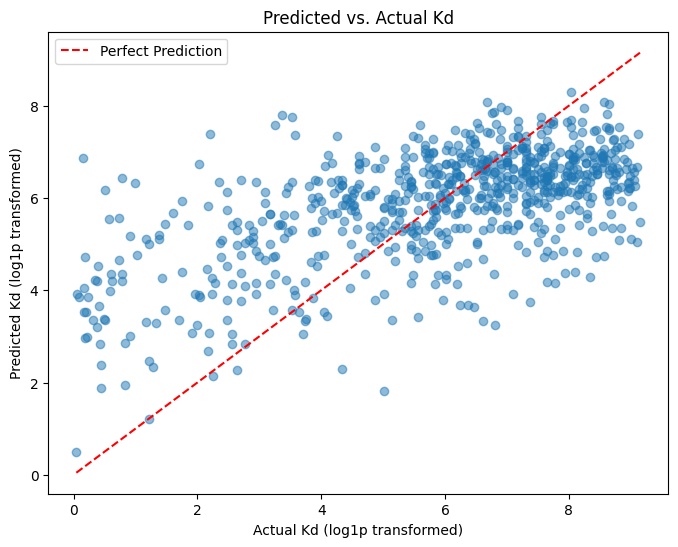

In [ ]:
# Scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Kd (log1p transformed)")
plt.ylabel("Predicted Kd (log1p transformed)")
plt.title("Predicted vs. Actual Kd")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Perfect Prediction')
plt.legend()
plt.show()

# Feature importance plot
# feature_importance = model.feature_importances_
# feature_names = ['Kinase', 'Compound'] + [f'Fingerprint_{i}' for i in range(X_fingerprints.shape[1])] # Assuming X_fingerprints is defined

# plt.figure(figsize=(12, 6))
# plt.bar(feature_names, feature_importance)
# plt.xticks(rotation=90)
# plt.xlabel("Features")
# plt.ylabel("Importance")
# plt.title("Feature Importance")
# plt.tight_layout()
# plt.show()